# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.configuration_utils import random_cmap, CONFIG_FILE_HEADER
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import estimate_diameters
from lib.shared.segment_cellpose import segment_cellpose
from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype_process.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# parameters for feature extraction
FOCI_CHANNEL = 2
CHANNEL_NAMES = ["DAPI", "COXIV", "CENPA", "WGA"]

Loading test image...
Applying illumination correction...
Example corrected image:


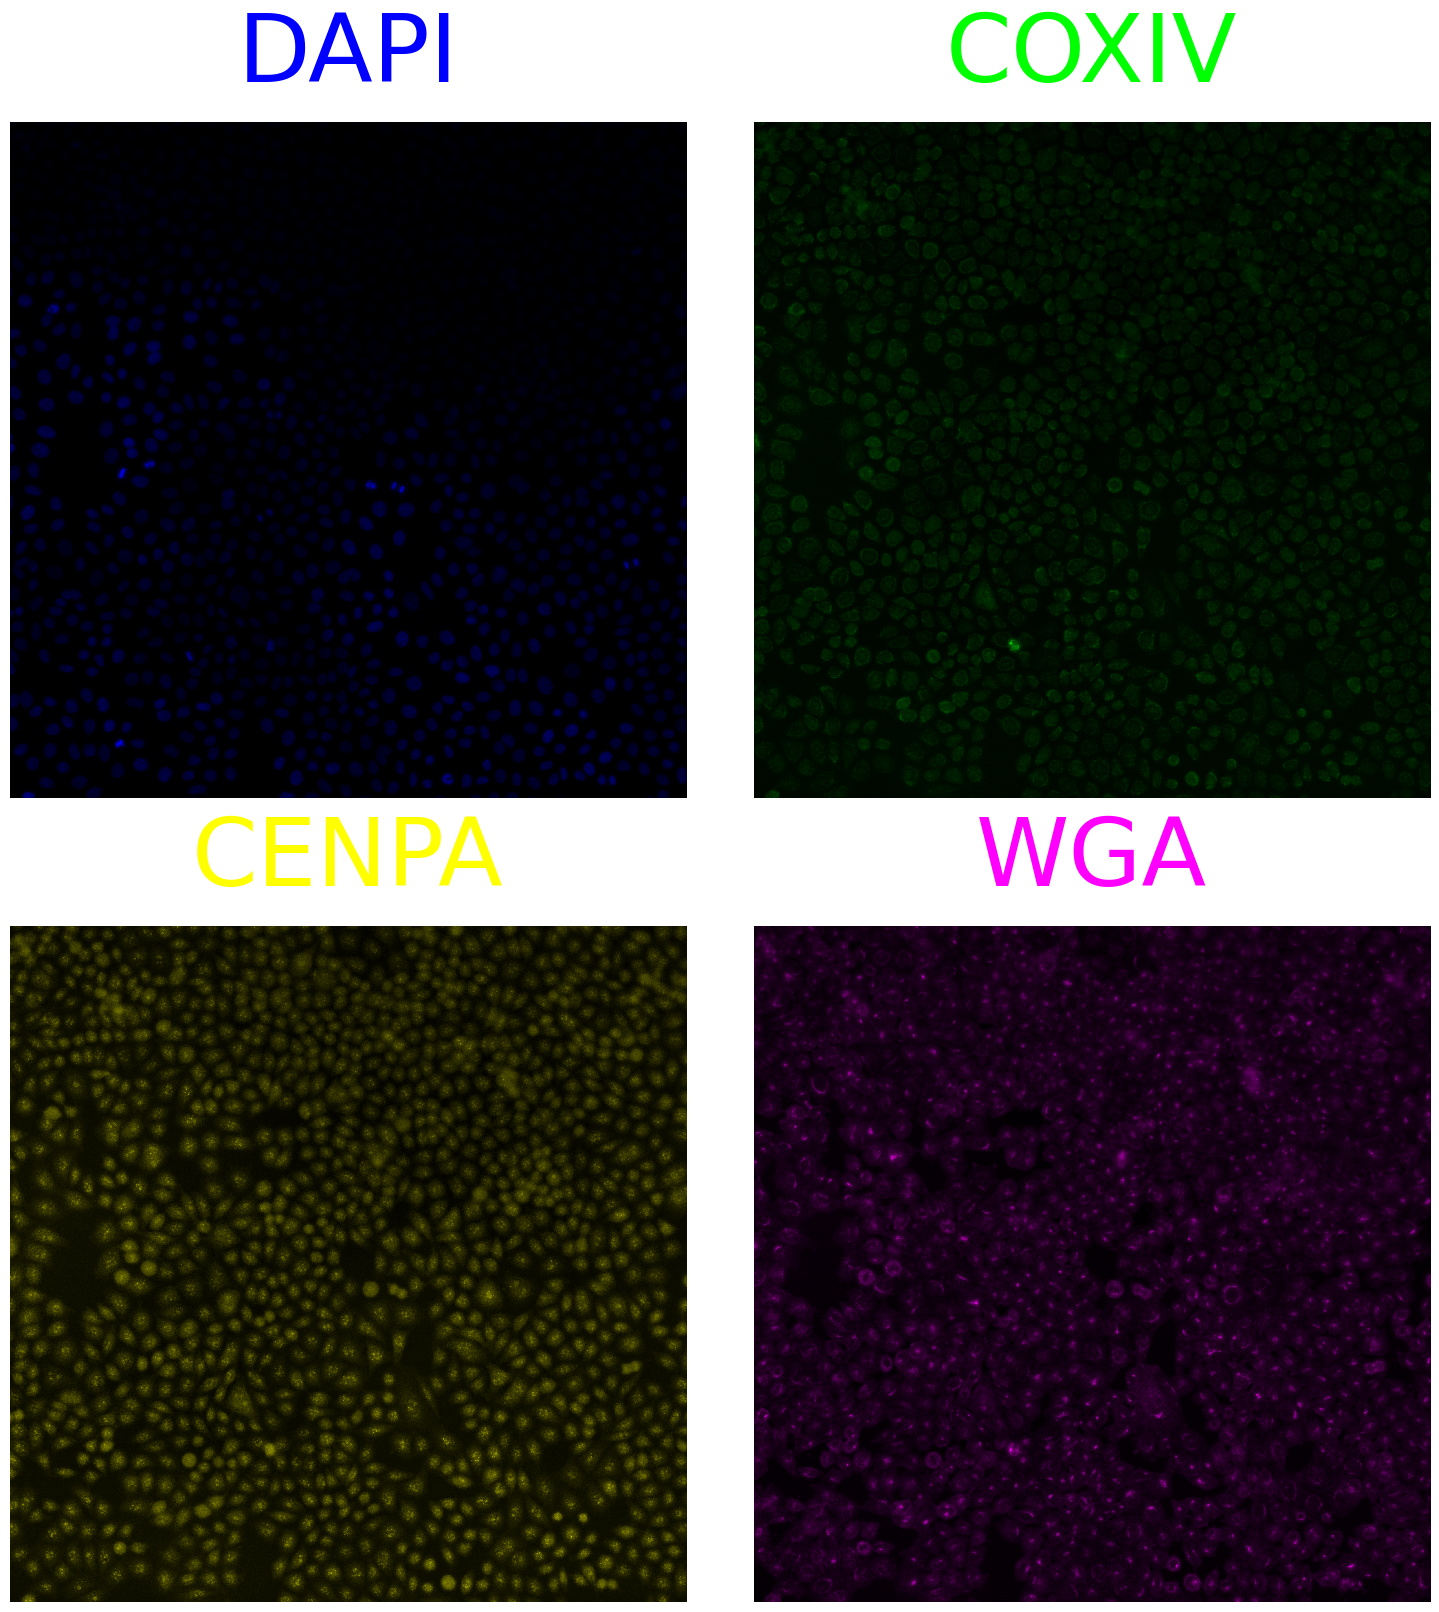

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names=CHANNEL_NAMES[0]
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names=CHANNEL_NAMES[1]
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names=CHANNEL_NAMES[2]
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names=CHANNEL_NAMES[3]
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Define parameters for CellPose segmentation
CYTO_CHANNEL = "COXIV"
CYTO_MODEL = "cyto3"

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

In [6]:
print("Estimating optimal cell and nuclei diameters...")
NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    cyto_model=CYTO_MODEL,
)

Estimating optimal cell and nuclei diameters...


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

Estimated nuclear diameter: 41.3 pixels
Estimating cell diameters...
Estimated cell diameter: 52.8 pixels


Segmenting cells...


found 1154 nuclei before removing edges
found 1213 cells before removing edges


removing edges


found 1082 nuclei before reconciling
found 1125 cells before reconciling


reconciling masks with method how=consensus


found 1019 nuclei/cells after reconciling


Number of nuclei segmented: 1019
Number of cells segmented: 1019
Example microplots for DAPI channel and nuclei segmentation:


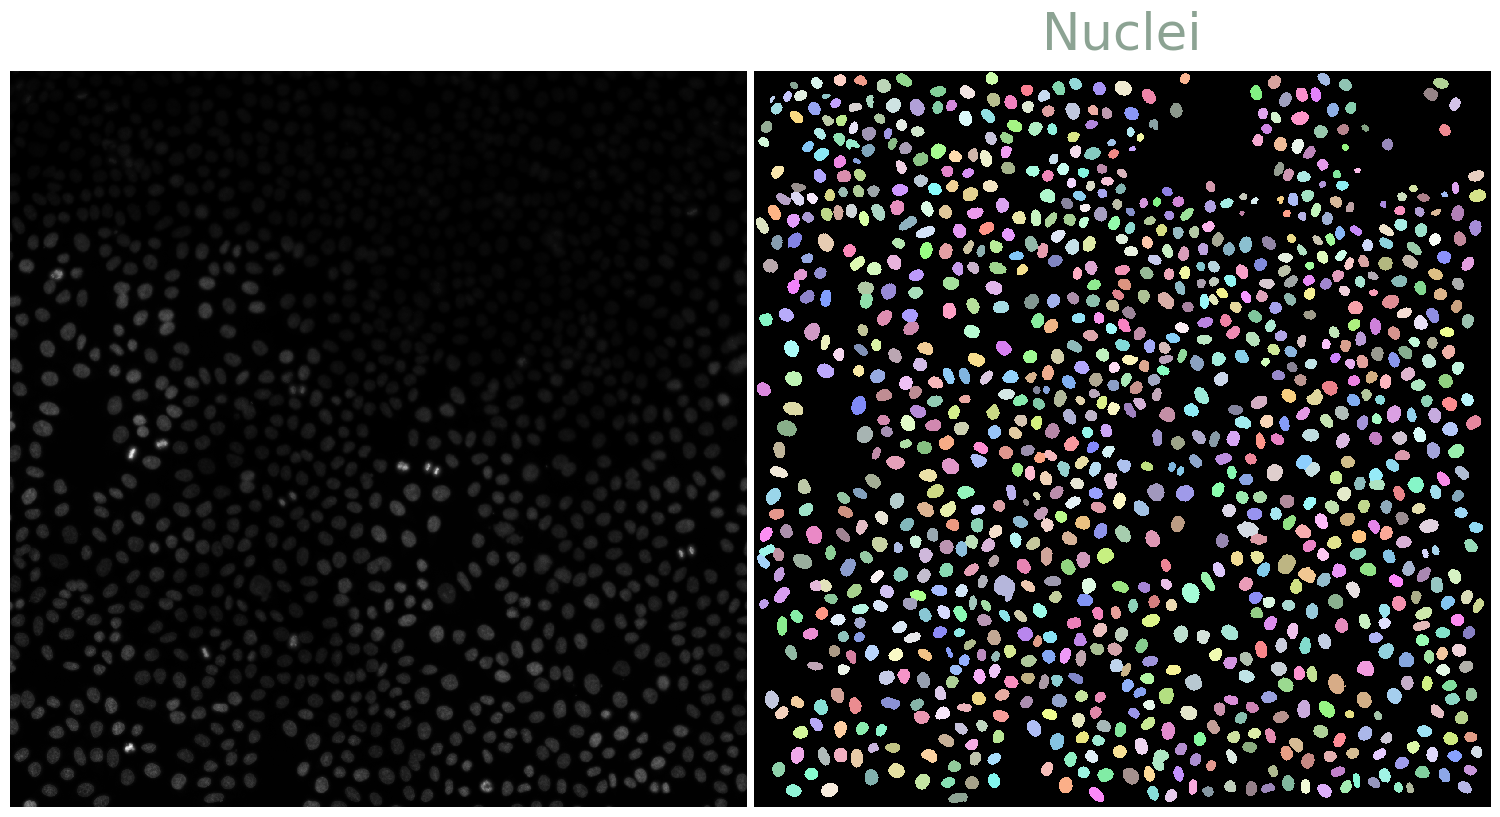

Example microplots for merged channels and cells segmentation:


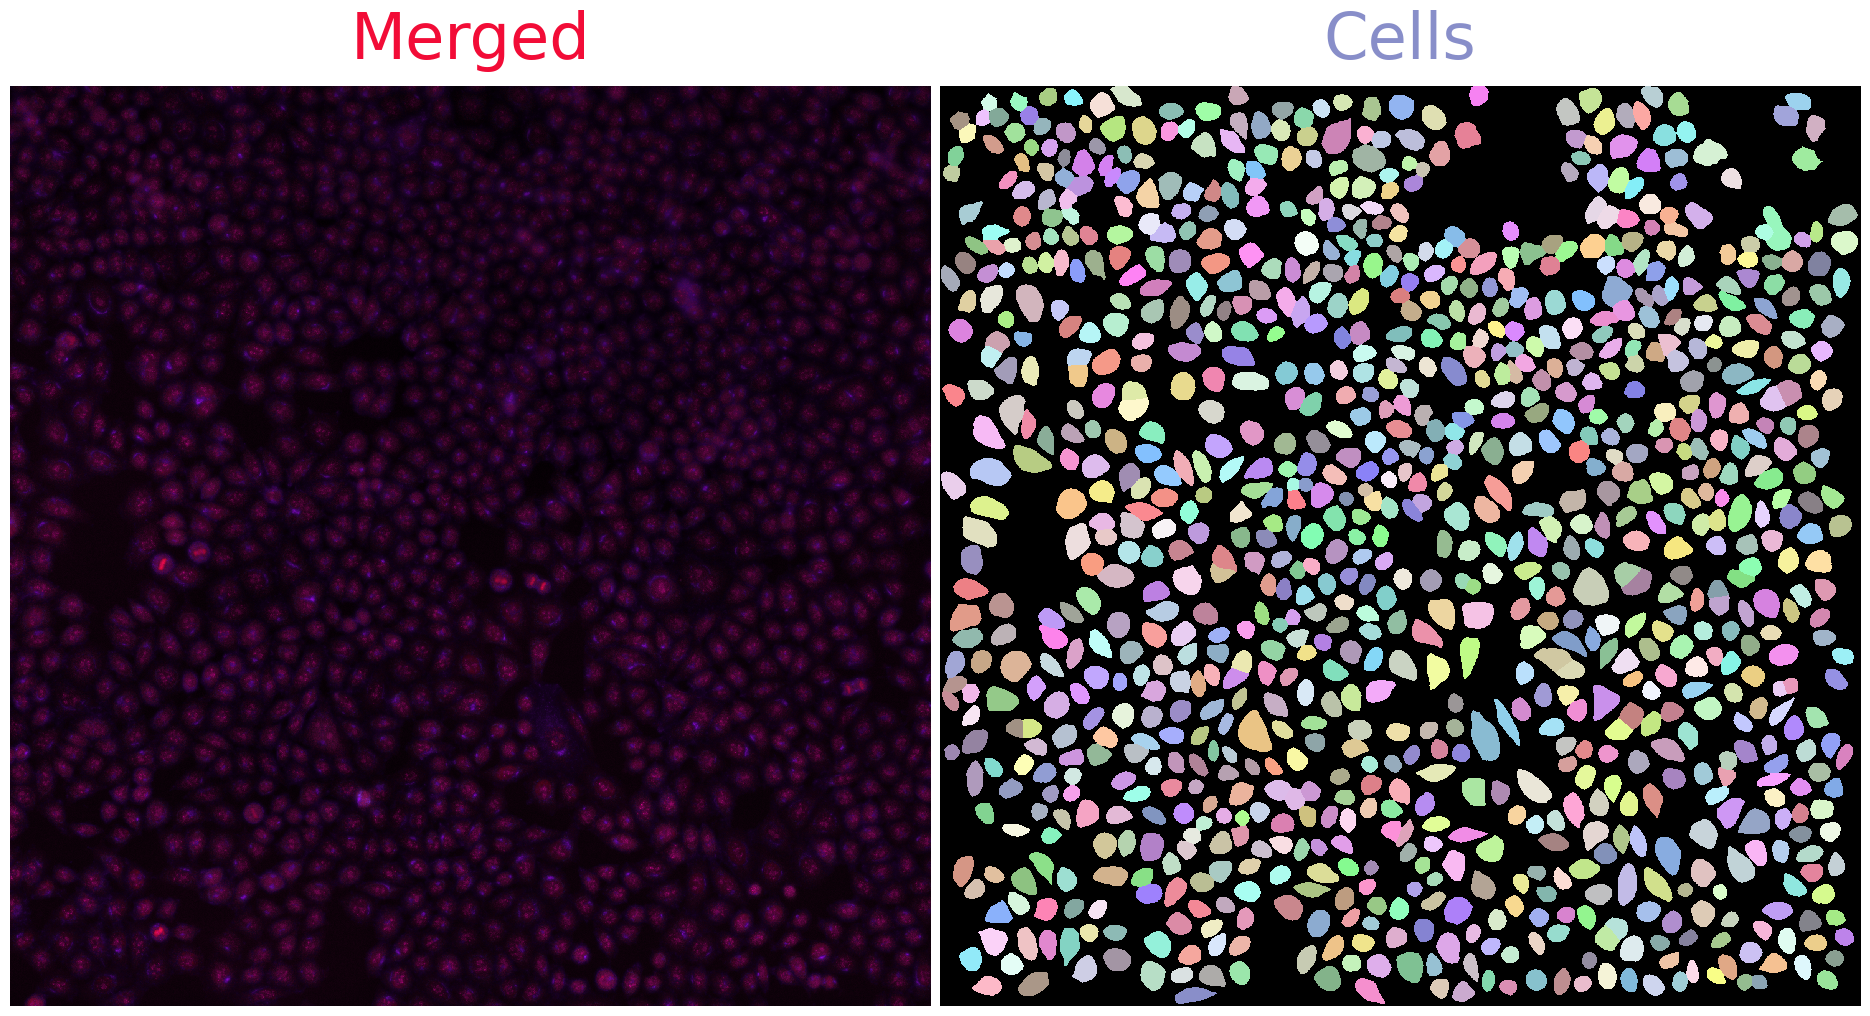

Example microplot for phenotype data annotated with segmenation:


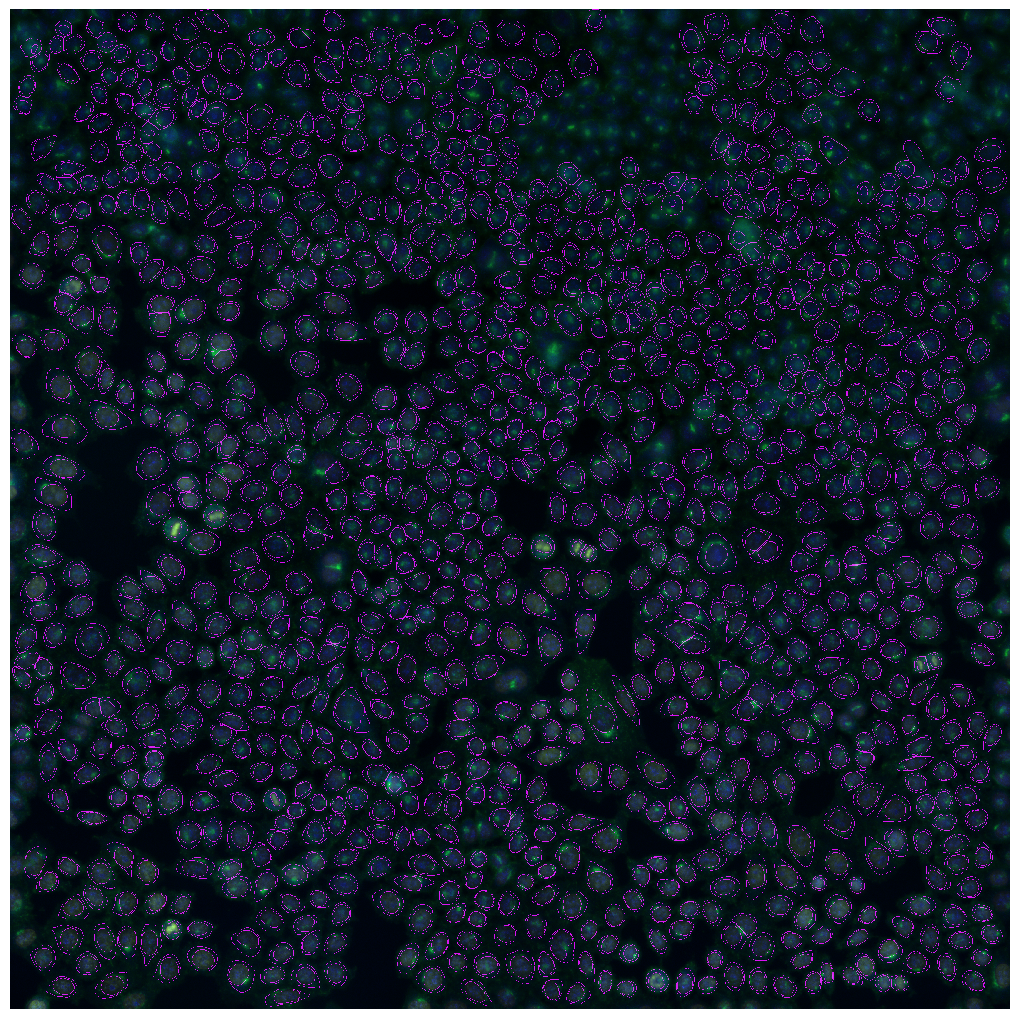

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 1019


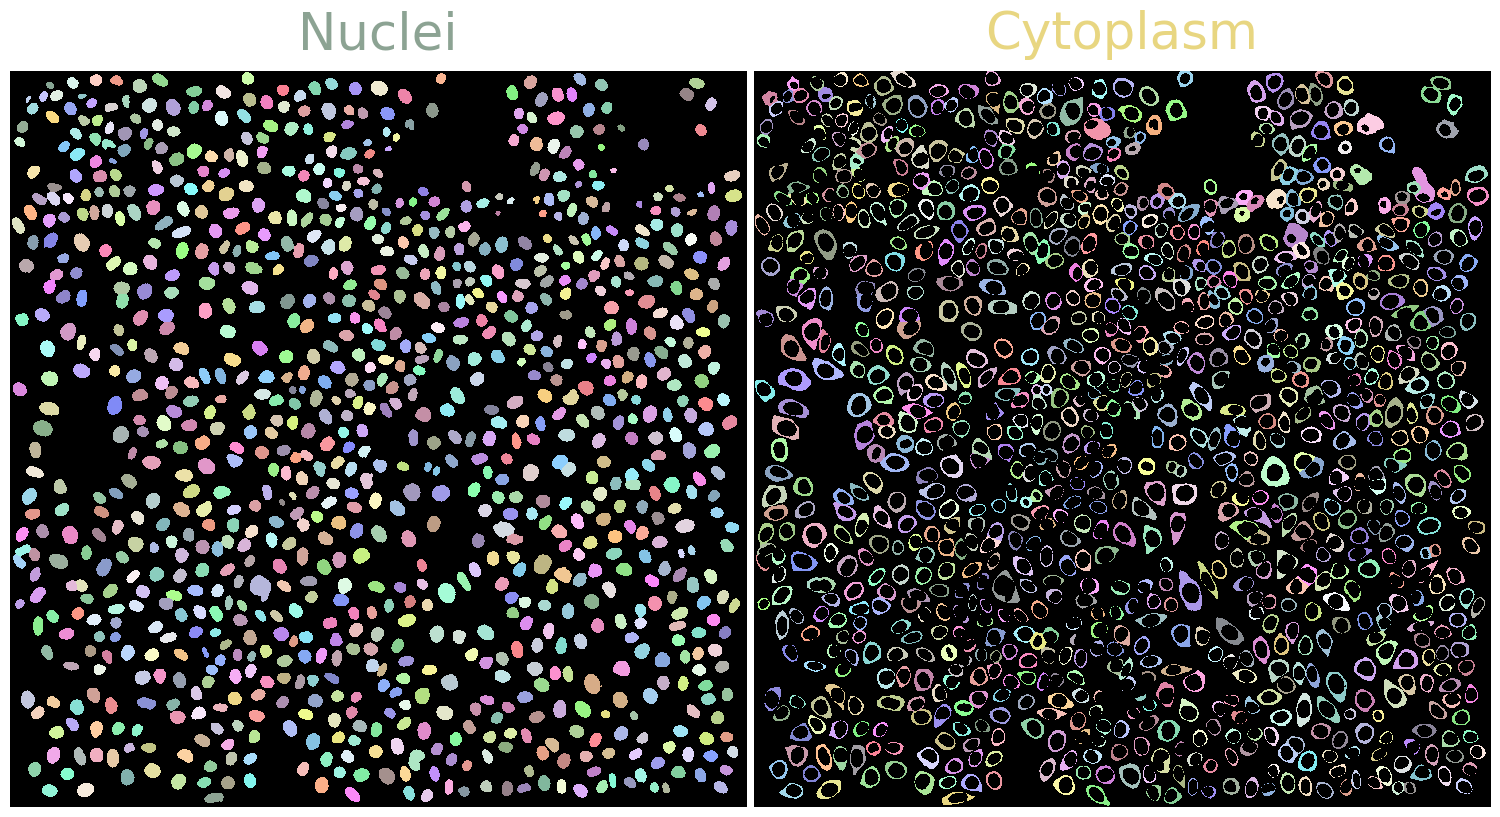

In [7]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cyto_model=CYTO_MODEL,
)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="DAPI")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

In [8]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    corrected_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_COXIV_int  nucleus_CENPA_int  \
0         1            813997             331601             373150   
1         2            620050             244186             322503   
2         3            621554             277181             366228   
3         4            430173             216793             270374   
4         5            541410             236426             316356   
...     ...               ...                ...                ...   
1014   1015           3128754             314404             417985   
1015   1016           3749365             380629             459685   
1016   1017           3785004             379733             496498   
1017   1018           3490408             321057             450626   
1018   1019           4756934             406581             579712   

      nucleus_WGA_int  nucleus_DAPI_mean  nucleus_COXIV_mean  \
0             2697916         618.538754          251.976444   
1             2087160         484.414062          190.770312   
2             2999082         387.261059          172.698442   
3             2032140         469.109051          236.415485   
4             2413710         433.822115          189.443910   
...               ...                ...                 ...   
1014          3015685        2321.034125          233.237389   
1015          3357049        3869.313725          392.805986   
1016          3487236        2171.545611          217.861733   
1017          3244274        2748.352756          252.800787   
1018          4257445        2860.453397          244.486470   

      nucleus_CENPA_mean  nucleus_WGA_mean  nucleus_DAPI_std  ...  \
0             283.548632       2050.088146        122.485354  ...   
1             251.955469       1630.593750         79.414806  ...   
2             228.179439       1868.586916         67.219432  ...   
3             294.846238       2216.074155         49.194705  ...   
4             253.490385       1934.062500         80.392988  ...   
...                  ...               ...               ...  ...   
1014          310.077893       2237.155045        408.201140  ...   
1015          474.391125       3464.446852       1110.501794  ...   
1016          284.852553       2000.709122        469.930305  ...   
1017          354.823622       2554.546457        453.246991  ...   
1018          348.594107       2560.099218        567.210185  ...   

      cell_number_neighbors_1  cell_percent_touching_1  \
0                           0                      0.0   
1                           0                      0.0   
2                           0                      0.0   
3                           0                      0.0   
4                           0                      0.0   
...                       ...                      ...   
1014                        0                      0.0   
1015                        0                      0.0   
1016                        0                      0.0   
1017                        0                      0.0   
1018                        0                      0.0   

      cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                        73.619445                      87.377018   
1                        57.947669                      71.207003   
2                        68.344004                      90.586308   
3                       109.012630                     131.029777   
4                        64.605784                      69.884486   
...                            ...                            ...   
1014                     60.603033                      60.766391   
1015                     55.072944                      74.830152   
1016                     70.167563                      84.986210   
1017                     60.603033                      70.691395   
1018                     59.743970                      70.009462   

      cell_angle_between_neig

In [9]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature

# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

In [14]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "cyto_model": CYTO_MODEL,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)